In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = "retina"

The original image has shape:  (250, 250, 3)
The gray scale image has shape:  (250, 250)


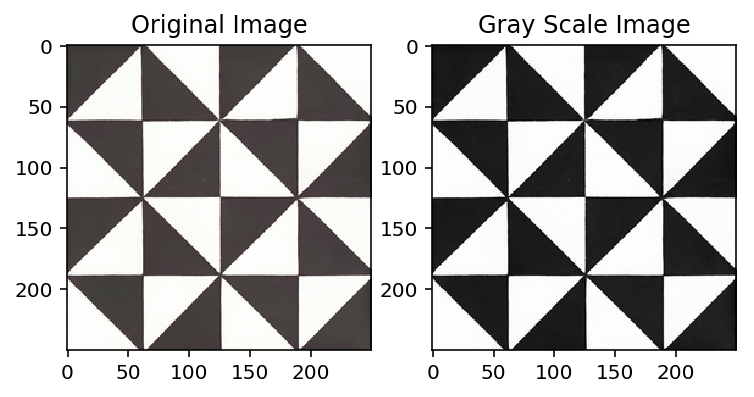

In [7]:
image = cv2.imread('./images/triangle_tile.jpeg')

# Convert the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Print the shape of the original and gray scale images
print('The original image has shape: ', original_image.shape)
print('The gray scale image has shape: ', gray_image.shape)

# Display the images
plt.subplot(121)
plt.imshow(original_image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Scale Image')
plt.show()

In [8]:
cell_size = (6, 6)

num_cells_per_block = (2, 2)

block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

h_stride = 1

v_stride = 1

block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

num_bins = 9        


win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

print('\nThe gray scale image has shape: ', gray_image.shape)
print()

print('HOG Descriptor Parameters:\n')
print('Window Size:', win_size)
print('Cell Size:', cell_size)
print('Block Size:', block_size)
print('Block Stride:', block_stride)
print('Number of Bins:', num_bins)
print()

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

hog_descriptor = hog.compute(gray_image)


The gray scale image has shape:  (250, 250)

HOG Descriptor Parameters:

Window Size: (246, 246)
Cell Size: (6, 6)
Block Size: (12, 12)
Block Stride: (6, 6)
Number of Bins: 9



In [9]:
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)

tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins

print('\nThe total number of elements in the HOG Feature Vector should be: ',
      tot_bx, 'x',
      tot_by, 'x',
      num_cells_per_block[0], 'x',
      num_cells_per_block[1], 'x',
      num_bins, '=',
      tot_els)

print('\nThe HOG Descriptor has shape:', hog_descriptor.shape)
print()


The total number of elements in the HOG Feature Vector should be:  40 x 40 x 2 x 2 x 9 = 57600

The HOG Descriptor has shape: (57600, 1)



The feature vector has shape: (57600, 1)
The reshaped feature vector has shape: (40, 40, 2, 2, 9)
The average gradient array has shape:  (41, 41, 9)


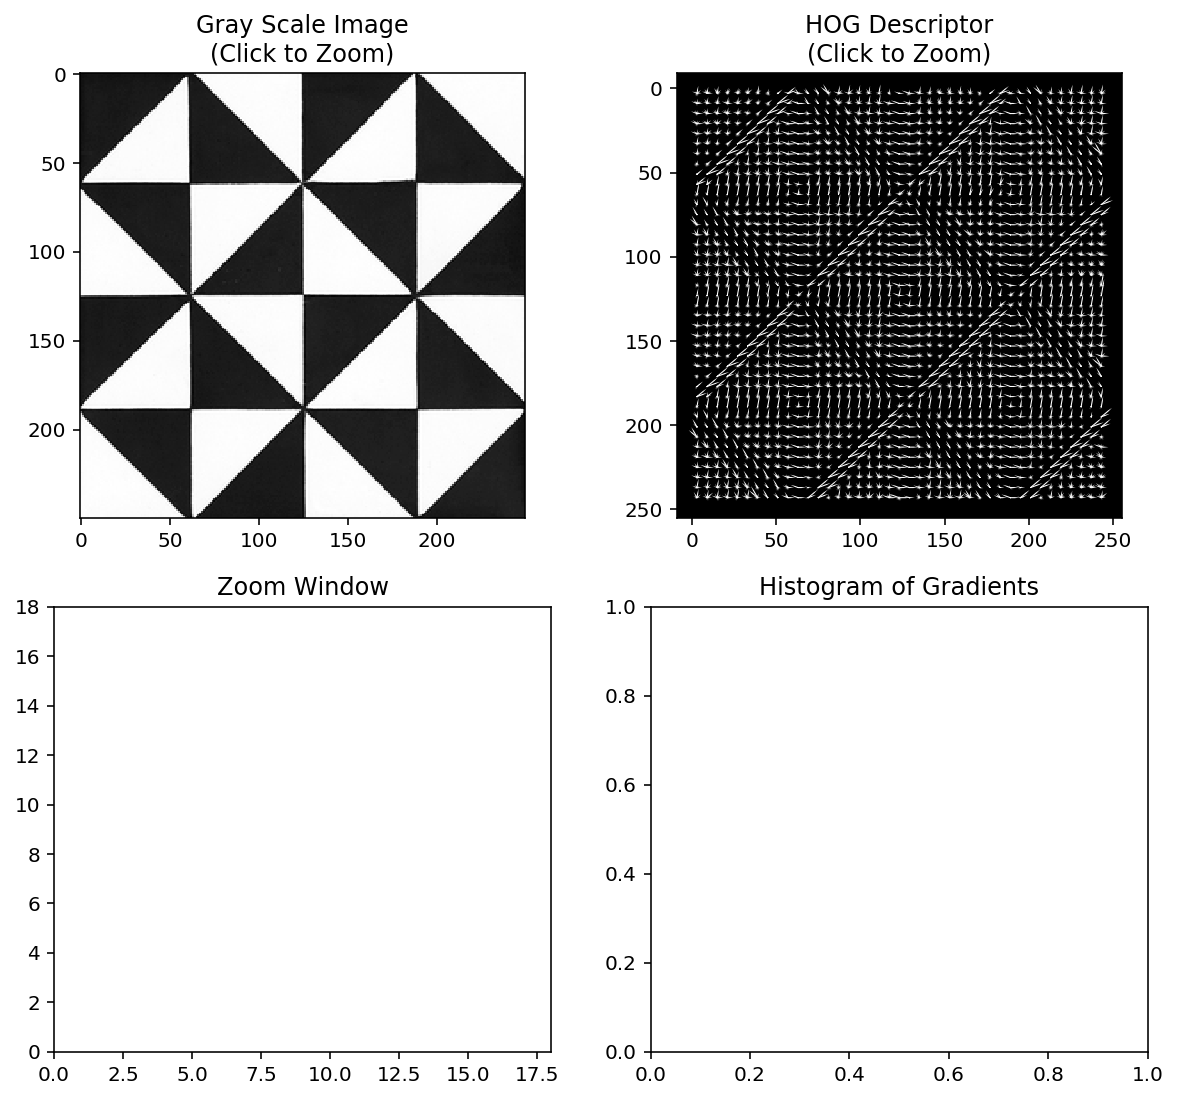

In [10]:
import copy
import matplotlib.patches as patches

plt.rcParams['figure.figsize'] = [9.8, 9]

hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

print('The feature vector has shape:', hog_descriptor.shape)

print('The reshaped feature vector has shape:', hog_descriptor_reshaped.shape)

ave_grad = np.zeros((y_cells, x_cells, num_bins))

print('The average gradient array has shape: ', ave_grad.shape) 

hist_counter = np.zeros((y_cells, x_cells, 1))

for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

ave_grad /= hist_counter
   
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

deg = np.linspace(0, np.pi, num_bins, endpoint = False)

U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

counter = 0

for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

fig, ((a,b),(c,d)) = plt.subplots(2,2)

a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

def onpress(event):
    
    if event.button != 1:
        return
    
    if event.inaxes in [a, b]:
        
        x, y = event.xdata, event.ydata
        
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()